In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np
import pandas
from create_train_test_val_maps import *
import pickle
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

%load_ext autoreload
%autoreload 2

In [2]:
# get global index from (row, col) index
def sub2ind(array_shape, row, col):
    ind = row*array_shape[1] + col
    if row < 0 or row >= array_shape[0]:
        ind = -1
    if col < 0 or col >= array_shape[1]:
        ind = -1
    return ind

# get (row, col) index from global index
def ind2sub(array_shape, ind):
    row = int(ind) / array_shape[1]
    col = ind % array_shape[1]
    if ind < 0:
        row = -1
        col = -1
    if ind >=  array_shape[0]*array_shape[1]:
        row = -1
        col = -1
    return (row, col)

def one_hot_labels(labels, num_classes):
    one_hot_labels = np.zeros((labels.size, num_classes))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels

def get_data(selected_codes, data_map, num_windows, window_size):
    X = []
    Y = []
    for vehicleID in data_map.keys():
        for ATA6code in data_map[vehicleID].keys():
            if ATA6code not in selected_codes:
                continue
            for window in data_map[vehicleID][ATA6code].keys():
                for sequence in data_map[vehicleID][ATA6code][window]:
                    seq_len = len(sequence)
                    Y.extend(list(np.ones((seq_len))*sub2ind((len(selected_codes),num_windows),selected_codes.index(ATA6code), window)))
                    X.extend(sequence.as_matrix())
    X = np.array(X).astype(float)
    Y = np.array(Y).astype(int)
    return X, Y

def create_two_stage_models(num_trees_code, num_trees_window, codes):
    code_clf = RandomForestClassifier(n_estimators=num_trees_code, n_jobs=-1, random_state=0, class_weight='balanced')
    window_clfs = {}
    for code in codes:
        window_clfs[code] = RandomForestClassifier(n_estimators=num_trees_window, n_jobs=-1, random_state=0, class_weight='balanced')
    return code_clf, window_clfs

def get_code_window_batches(selected_codes, data_map, num_windows, window_size):
    X_map = {}
    Y_code_map = {}
    Y_window_map = {}
    for code in selected_codes:
        Y_window_map[code] = []
        Y_code_map[code] = []
        X_map[code] = []

    for vehicleID in data_map.keys():
        for ATA6code in data_map[vehicleID].keys():
            if ATA6code not in selected_codes:
                continue
            for window in data_map[vehicleID][ATA6code].keys():
                for sequence in data_map[vehicleID][ATA6code][window]:
                    seq_len = len(sequence)
                    Y_code_map[ATA6code].extend(list(np.ones((seq_len))*ATA6code))
                    Y_window_map[ATA6code].extend(list(np.ones((seq_len))*window))
                    X_map[ATA6code].extend(sequence.as_matrix())
    
    X = []
    Y_code = []
    for code in selected_codes:
        Y_code.extend(Y_code_map[code])
        X.extend(X_map[code])
        X_map[code] = np.asarray(X_map[code]).astype(float)
        Y_window_map[code] = np.asarray(Y_window_map[code]).astype(int)
        Y_code_map[code] = np.asarray(Y_code_map[code]).astype(int)
        
    Y_code = np.array(Y_code).astype(int)
    X = np.array(X).astype(float)
        
    return X, X_map, Y_code, Y_code_map, Y_window_map

def save_file(filename, m):
    with open(filename+'.pkl', 'wb') as handle:
        pickle.dump(m, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def open_file(filename):
    m = None
    with open(filename+'.pkl', 'rb') as handle:
        m = pickle.load(handle)
    return m

In [3]:
selected_codes = [0, 45021, 44004, 43004, 45008, 45002, 45007]

In [11]:
## tune hyperparameters
num_epochs = 2
batch_size = 100
num_classes = 70
num_features = 61
num_trees = 70
max_nodes = 10000

## selected windows to report on
hyper_tuples = [(1,500), (2,250), (5,100), (10, 50)]
trees = [10,30, 40, 50, 60, 70, 100,200,300]#[10, 30, 40, 50, 60, 70, 100]

val_acc_all = {}
val_error_all = {}

for num_windows, window_size in hyper_tuples:
    train_combined, val_combined, test_combined = load_maps(num_windows, window_size)

    val_acc_all[(num_windows,window_size)] = {}
    val_acc_trees = val_acc_all[(num_windows,window_size)]
    val_error_all[(num_windows,window_size)] = {}
    val_error_trees = val_error_all[(num_windows,window_size)]
    
    X_train, X_train_map, y_train_code, y_train_code_map, y_train_window = get_code_window_batches(selected_codes, train_combined, num_windows, window_size)
    X_val, X_val_map, y_val_code, y_val_code_map, y_val_window = get_code_window_batches(selected_codes, val_combined, num_windows, window_size)
    
    for num_trees in trees:
        print("Training tree {} with num {} and size {}".format(num_trees, num_windows, window_size))
        
        code_clf, window_clfs = create_two_stage_models(num_trees, num_trees, selected_codes)

        val_acc_trees[num_trees] = {'code':{}, 'window': {}}
        val_error_trees[num_trees] = {}
        
        #train
        code_clf.fit(X_train, y_train_code)
        for code in selected_codes:
            window_clfs[code].fit(X_train_map[code], y_train_window[code])

        # val
        for code in selected_codes:
            val_acc_trees[num_trees]['code'][code] = code_clf.score(X_val_map[code], y_val_code_map[code])
            val_acc_trees[num_trees]['window'][code] = window_clfs[code].score(X_val_map[code], y_val_window[code])
            val_error_trees[num_trees][code] = mean_squared_error(window_clfs[code].predict(X_val_map[code]), y_val_window[code])

Training tree 10 with num 1 and size 500
Training tree 30 with num 1 and size 500
Training tree 40 with num 1 and size 500
Training tree 50 with num 1 and size 500
Training tree 60 with num 1 and size 500
Training tree 70 with num 1 and size 500
Training tree 100 with num 1 and size 500
Training tree 200 with num 1 and size 500
Training tree 300 with num 1 and size 500
Training tree 10 with num 2 and size 250
Training tree 30 with num 2 and size 250
Training tree 40 with num 2 and size 250
Training tree 50 with num 2 and size 250
Training tree 60 with num 2 and size 250
Training tree 70 with num 2 and size 250
Training tree 100 with num 2 and size 250
Training tree 200 with num 2 and size 250
Training tree 300 with num 2 and size 250
Training tree 10 with num 5 and size 100
Training tree 30 with num 5 and size 100
Training tree 40 with num 5 and size 100
Training tree 50 with num 5 and size 100
Training tree 60 with num 5 and size 100
Training tree 70 with num 5 and size 100
Training t

In [12]:
save_file('val_acc_all_two-stage_smoothed_50', val_acc_all)

In [13]:
save_file('val_error_all_two-stage_smoothed_50', val_error_all)

In [26]:
# take mean of windows
val_mean_map = {}
for tup in hyper_tuples:
    val_mean_map[tup] = {}
    for tree in val_acc_all[tup].keys():
        code_acc = np.mean(list(val_acc_all[tup][tree]['code'].values()))
        window_acc = np.mean(list(val_acc_all[tup][tree]['window'].values()))
        val_mean_map[tup][tree] = [code_acc, window_acc]

In [27]:
val_mean_map

{(1, 500): {10: [0.28947888431082841, 1.0],
  30: [0.28866649672971306, 1.0],
  40: [0.28897649569873324, 1.0],
  50: [0.28900047467526829, 1.0],
  60: [0.29321970536973424, 1.0],
  70: [0.29163417205440173, 1.0],
  100: [0.29222105653663916, 1.0],
  200: [0.2918501920297647, 1.0],
  300: [0.29148088480052631, 1.0]},
 (2, 250): {10: [0.28148111593403108, 0.64664713940007934],
  30: [0.28539899510036293, 0.64808765565325643],
  40: [0.2879979770687206, 0.64912154313220416],
  50: [0.28562421928384335, 0.65206239486688666],
  60: [0.28634442532608517, 0.65369028766410187],
  70: [0.2892866341254523, 0.65303722311843571],
  100: [0.29331887528884498, 0.65012280962016422],
  200: [0.29397569005935525, 0.65050405740021611],
  300: [0.29221489715494442, 0.65067762936666995]},
 (5, 100): {10: [0.28337488281776324, 0.34384088726171286],
  30: [0.28670511716860092, 0.35835364805204994],
  40: [0.28632401026851834, 0.34564250464448099],
  50: [0.28477826888322905, 0.34423078653913536],
  60: [0.

In [28]:
# make matrix out of mean scores
score_mat = np.zeros((len(hyper_tuples), len(trees), 2))
s_hyper_tuples = sorted(hyper_tuples)
s_trees = sorted(trees)

for tup in range(len(s_hyper_tuples)):
    for num_trees in range(len(s_trees)):
        mean_tup = val_mean_map[s_hyper_tuples[tup]][s_trees[num_trees]]
        score_mat[tup, num_trees] = np.asarray(mean_tup)

In [31]:
# find best trees
s_hyper_tuples = sorted(hyper_tuples)
s_trees = sorted(trees)
best_trees = np.argsort(np.sum(np.sum(score_mat, axis=2), axis=0))
for tree_i in best_trees[::-1][:3]:
    print(s_trees[tree_i])

300
100
200


In [142]:
np.sum(score_mat, axis=1)

array([[ 2.78533333,  5.        ],
       [ 2.71502222,  3.18942569],
       [ 2.33171429,  1.51228691],
       [ 2.59763889,  1.66150211],
       [ 2.60773109,  1.7137381 ],
       [ 2.44242254,  1.59003448],
       [ 2.41036415,  1.15189493],
       [ 2.41473684,  1.29455088]])

In [141]:
# multiply each ave accuracy by the granularity to see "best value" for window size
np.mean(np.sum(score_mat, axis=2), axis=1)*np.array(s_hyper_tuples)[:,0]

array([ 1.55706667,  2.36177916,  3.8440012 ,  4.259141  ,  4.32146919,
        4.03245701,  7.12451815,  7.41857544])

In [8]:
def get_plots(Y, x, z_labels, title, xlabel, ylabel, tic_mult=1, offset=0):
    for i in range(len(z_labels)):
        plot_label = z_labels[i]
        plt.plot(x,Y[i],label=plot_label)

    ax = plt.gca() # grab the current axis
    ax.set_xticks(x[offset::tic_mult]) # choose which x locations to have ticks
    ax.set_xticklabels(x[offset::tic_mult]) # set the labels to display at those ticks
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    legend = plt.legend(loc="upper right",bbox_to_anchor=(1,1), title="(#Win,WSize)")
    plt.rcParams["figure.figsize"] = [6,5]
    plt.savefig(title.replace(" ", "_"), bbox_extra_artists=(legend,), bbox_inches="tight")
    plt.show()
    
def get_z_labels(hyper_tuples):
    return [str(tup) for tup in hyper_tuples]

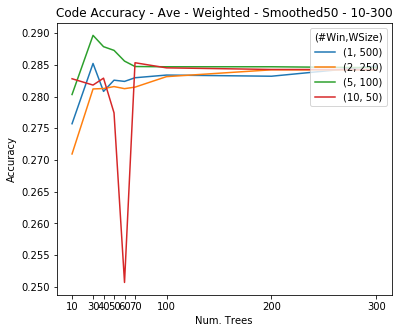

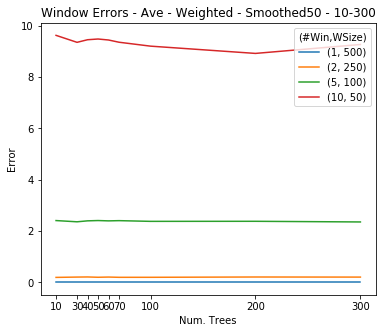

In [14]:
## plot trees plots
hyper_tuples = [(1,500), (2,250), (5,100), (10, 50)]
x_coord = trees
z_labels = get_z_labels(hyper_tuples)

code_accuracies_list = []
window_errors_list = []
for tup in hyper_tuples:
    code_acc_tup_tree = []
    window_error_tup_tree = []
    for tree in trees:
        code_acc_tup_tree.append(np.mean(list(val_acc_all[tup][tree]['code'].values())))
        window_error_tup_tree.append(np.mean(np.asarray(list(val_error_all[tup][tree].values()))))
        
    code_accuracies_list.append(code_acc_tup_tree)
    window_errors_list.append(window_error_tup_tree)

plt.figure()
get_plots(code_accuracies_list, x_coord, z_labels, "Code Accuracy - Ave - Weighted - Smoothed50 - 10-300", "Num. Trees", "Accuracy")

plt.figure()
get_plots(window_errors_list, x_coord, z_labels, "Window Errors - Ave - Weighted - Smoothed50 - 10-300", "Num. Trees", "Error")

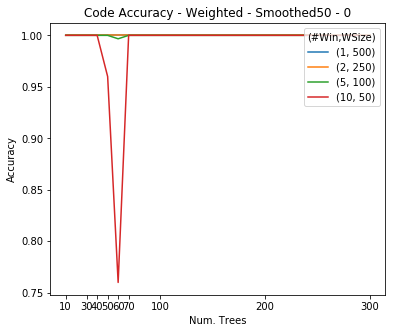

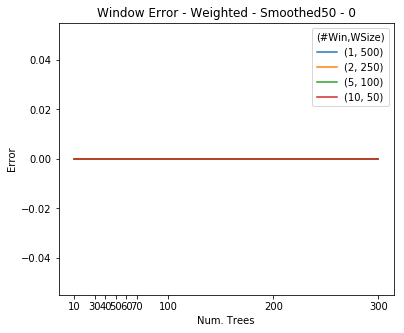

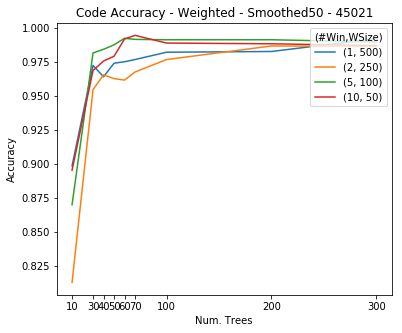

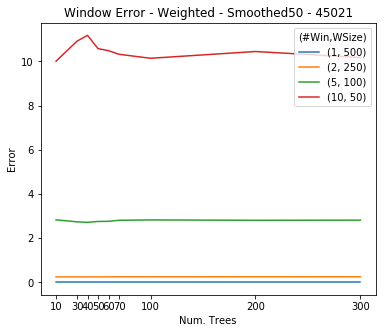

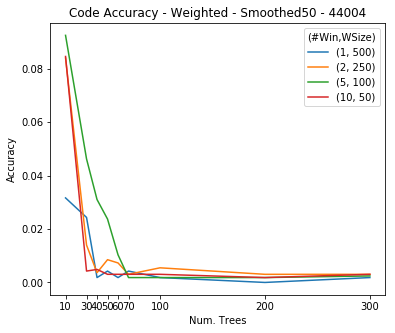

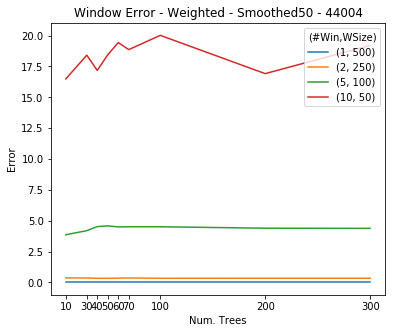

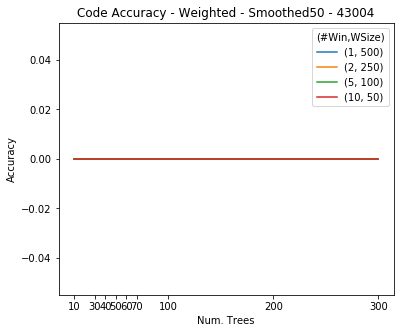

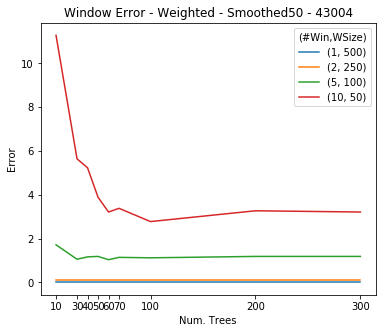

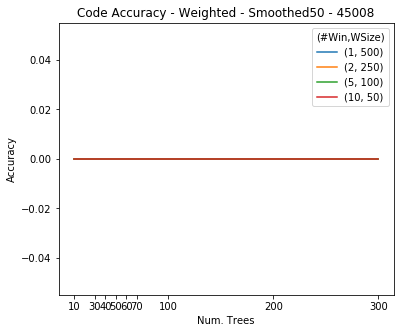

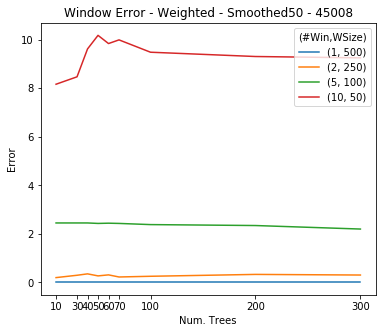

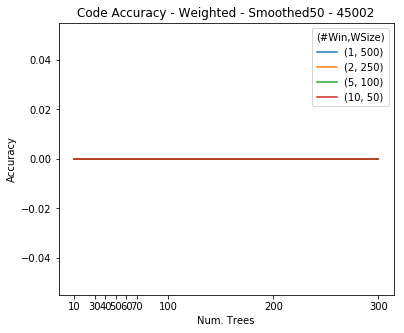

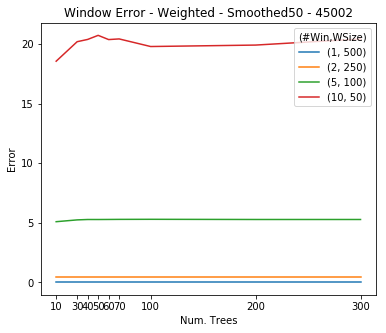

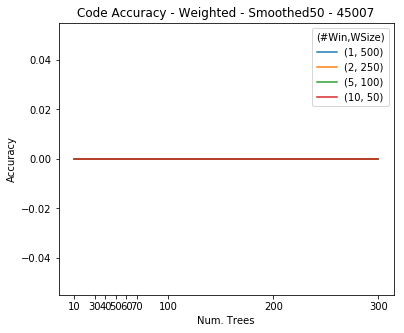

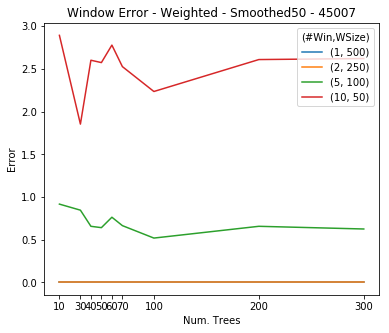

In [15]:
## plot trees with codes plots
hyper_tuples = [(1,500), (2,250), (5,100), (10, 50)]
x_coord = trees
z_labels = get_z_labels(hyper_tuples)

for code in selected_codes:
    code_accuracies_list = []
    window_errors_list = []
    for tup in hyper_tuples:
        code_acc_tup_tree = []
        window_error_tup_tree = []
        for tree in trees:
            code_acc_tup_tree.append(val_acc_all[tup][tree]['code'][code])
            window_error_tup_tree.append(val_error_all[tup][tree][code])
        code_accuracies_list.append(code_acc_tup_tree)
        window_errors_list.append(window_error_tup_tree)

    plt.figure()
    get_plots(code_accuracies_list, x_coord, z_labels, "Code Accuracy - Weighted - Smoothed50 - {}".format(code), "Num. Trees", "Accuracy")

    plt.figure()
    get_plots(window_errors_list, x_coord, z_labels, "Window Error - Weighted - Smoothed50 - {}".format(code), "Num. Trees", "Error")

In [16]:
## determine standard dev, mean for best model for each hyper_tuple

# best number of trees
num_trees_code = 70
num_trees_window = 10

hyper_tuples = [(1,500), (2,250), (5,100), (10, 50)]
code_scores = {}
window_errors = {}
code_means = {}
code_stds = {}
window_means = {}
window_abs_means = {}
window_stds = {}

for tup in hyper_tuples:
    num_windows, window_size = tup
    train_combined, val_combined, test_combined = load_maps(num_windows, window_size)
    X_train, X_train_map, y_train_code, _, y_train_window = get_code_window_batches(selected_codes, train_combined, num_windows, window_size)
    X_test, X_test_map, y_test_code, y_test_code_map, y_test_window = get_code_window_batches(selected_codes, test_combined, num_windows, window_size)

    # train
    code_clf, window_clfs = create_two_stage_models(num_trees_code, num_trees_window, selected_codes)
    code_clf.fit(X_train, y_train_code)
    for code in selected_codes:
        window_clfs[code].fit(X_train_map[code], y_train_window[code])

    # test
    code_scores[tup] = {}
    window_errors[tup] = {}
    window_abs_errors = []

    for code in selected_codes:
        if len(X_test_map[code])>0:
            code_scores[tup][code] = code_clf.score(X_test_map[code], y_test_code_map[code])
            prediction = window_clfs[code].predict(X_test_map[code])
            window_errors[tup][code] = mean_squared_error(prediction, y_test_window[code])
            window_abs_errors.append(mean_absolute_error(prediction, y_test_window[code]))

    code_means[tup] = np.mean(list(code_scores[tup].values()))
    code_stds[tup] = np.std(list(code_scores[tup].values()))
    window_means[tup] = np.mean(list(window_errors[tup].values()))
    window_stds[tup] = np.std(list(window_errors[tup].values()))
    window_abs_means[tup] = np.mean(window_abs_errors)

In [17]:
save_file('test_code_scores_opt_smooth50', code_scores)
save_file('test_window_errors_opt_smooth50', window_errors)
save_file('test_code_means_opt_smooth50', code_means)
save_file('test_code_stds_opt_smooth50', code_stds)
save_file('test_window_means_opt_smooth50', window_means)
save_file('test_window_abs_means_opt_smooth50', window_abs_means)
save_file('test_window_stds_opt_smooth50', window_stds)

In [18]:
window_means

{(1, 500): 0.0,
 (2, 250): 0.098366935057220634,
 (5, 100): 1.3320753883735128,
 (10, 50): 5.3518089660157377}

In [19]:
window_stds

{(1, 500): 0.0,
 (2, 250): 0.17108979267969368,
 (5, 100): 1.1561265375596197,
 (10, 50): 4.7880108787935836}

In [20]:
code_means

{(1, 500): 0.2857142857142857,
 (2, 250): 0.29582806573957016,
 (5, 100): 0.26921375912847095,
 (10, 50): 0.23936622949977471}

In [21]:
code_stds

{(1, 500): 0.45175395145262565,
 (2, 250): 0.4460000684527628,
 (5, 100): 0.40920318975990216,
 (10, 50): 0.38368044627100933}

In [22]:
## create comparison matrix for comparison metrics
comparison_matrix = {}
for tup in hyper_tuples:
    if tup == (1,500): # handle zero/zero case
        comparison_matrix[tup] = [(code_means[tup]/code_stds[tup]), 0]
    else:
        comparison_matrix[tup] = [(code_means[tup]/code_stds[tup]), -window_stds[tup]*window_means[tup]]

In [23]:
save_file('comparison_matrix_smooth50', comparison_matrix)

In [24]:
comparison_matrix

{(1, 500): [0.63245553203367577, 0],
 (2, 250): [0.66329152541576841, -0.016829578525476771],
 (5, 100): [0.65789750878147046, -1.5400477065286551],
 (10, 50): [0.62386872155246731, -25.624519550508392]}

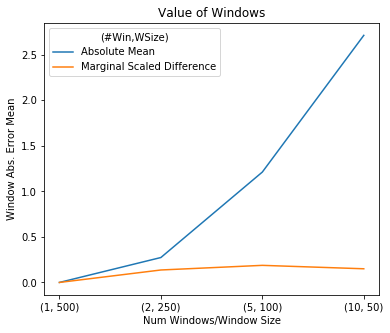

In [281]:
# plot means
plt.figure()

means = [window_abs_means[i] for i in hyper_tuples]

plt.plot(range(len(hyper_tuples)), means, label='Absolute Mean')
diff_start = [0]
diff_start.extend(means)
marginal_difference = [(diff_start[i+1] - diff_start[i])/hyper_tuples[i][0] for i in range(len(hyper_tuples))]
plt.plot(range(len(hyper_tuples)), marginal_difference, label='Marginal Scaled Difference')
ax = plt.gca() # grab the current axis
ax.set_xticks(range(len(hyper_tuples))) # choose which x locations to have ticks
ax.set_xticklabels(hyper_tuples) # set the labels to display at those ticks
plt.xlabel('Num Windows/Window Size')
plt.ylabel('Window Abs. Error Mean')
plt.title('Value of Windows')
plt.rcParams["figure.figsize"] = [6,5]
legend = plt.legend(loc="upper left", title="(#Win,WSize)")
plt.savefig('Value_of_Windows', bbox_extra_artists=(legend,), bbox_inches="tight")
plt.show()

In [258]:
## feature selection prep
col_names = list(test_combined[519][44003][0][0])
features_ind_sort = np.argsort(code_clf.feature_importances_)[::-1]

# best number of trees
num_trees_code = 40
num_trees_window = 10

In [287]:
## feature selection
code_acc_fs = {}
window_err_fs = {}

for tup in hyper_tuples:
    num_windows, window_size = tup
    train_combined, val_combined, test_combined = load_maps(num_windows, window_size)
    X_train, X_train_map, y_train_code, y_train_code_map, y_train_window = get_code_window_batches(selected_codes, train_combined, num_windows, window_size)
    X_val, X_val_map, y_val_code, y_val_code_map, y_val_window = get_code_window_batches(selected_codes, val_combined, num_windows, window_size)
    
    code_acc_fs[tup] = {}
    window_err_fs[tup] = {}
    
    for to_keep_ind in range(1,len(col_names)+1):
        features_ind = features_ind_sort[:to_keep_ind]

        # train
        code_clf, window_clfs = create_two_stage_models(num_trees_code, num_trees_window, selected_codes)
        code_clf.fit(X_train[:, features_ind], y_train_code)
        for code in selected_codes:
            window_clfs[code].fit(X_train_map[code][:, features_ind], y_train_window[code])

        # val
        code_acc_fs[tup][to_keep_ind] = {}
        window_err_fs[tup][to_keep_ind] = {}
        for code in selected_codes:
            if len(X_val_map[code])>0:
                code_acc_fs[tup][to_keep_ind][code] = code_clf.score(X_val_map[code][:, features_ind], y_val_code_map[code])
                window_err_fs[tup][to_keep_ind][code] = mean_squared_error(window_clfs[code].predict(X_val_map[code][:, features_ind]), y_val_window[code])

In [289]:
window_err_fs[(2,250)][1]

{0: 0.0,
 43004: 0.33333333333333331,
 44004: 0.55555555555555558,
 45002: 0.5,
 45007: 0.5,
 45008: 0.5,
 45021: 0.48727272727272725}

In [291]:
save_file('feature_selection_acc', code_acc_fs)
save_file('feature_selection_err', window_err_fs)

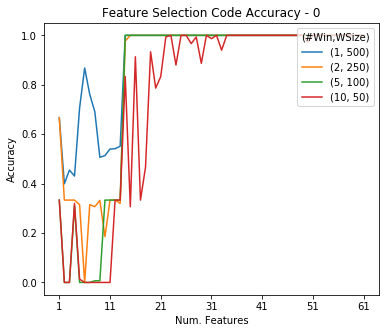

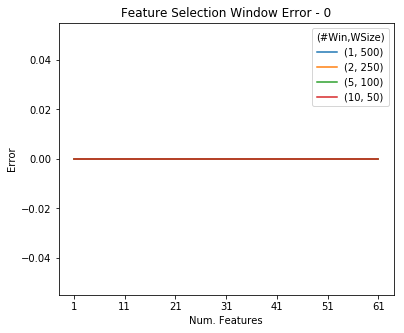

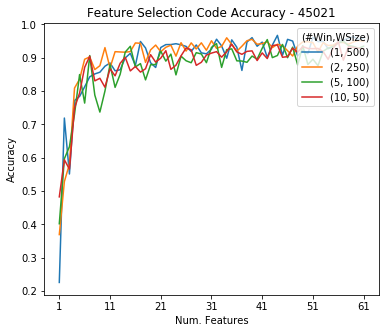

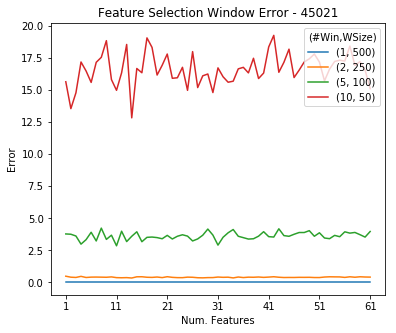

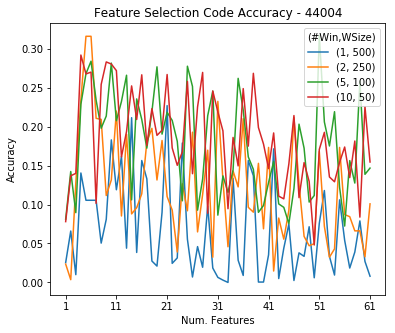

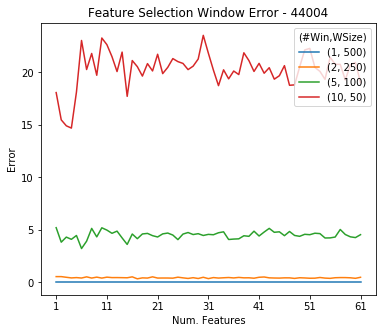

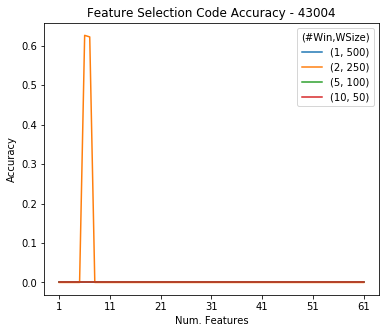

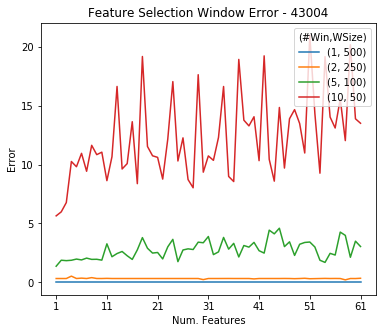

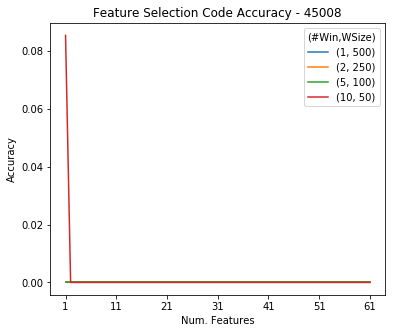

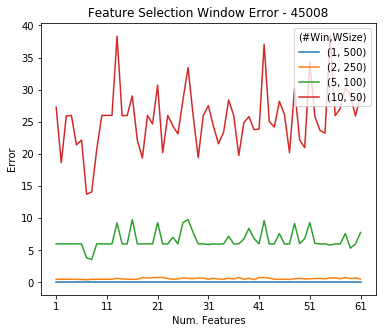

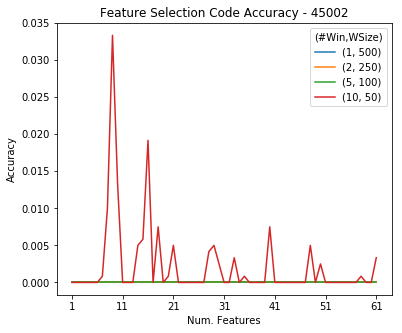

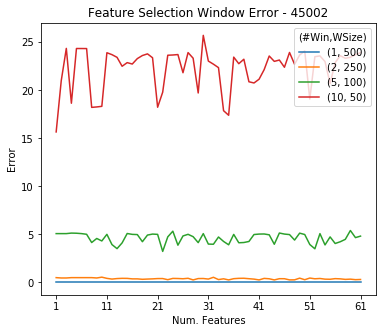

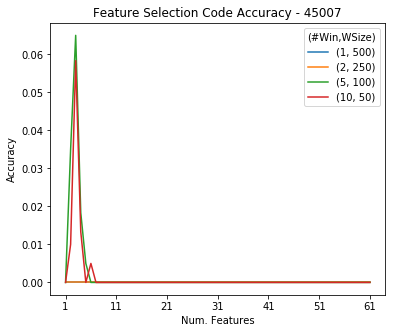

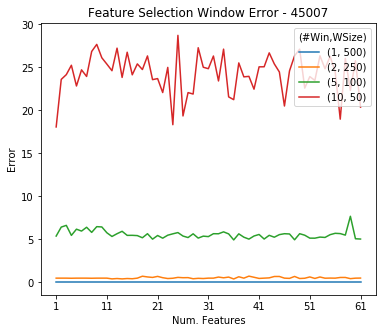

In [292]:
## plot feature selection
hyper_tuples = [(1,500), (2,250), (5,100), (10, 50)]
x_coord = range(1,len(col_names)+1) ## number of features, 61 included, sorted by greatest importance
z_labels = get_z_labels(hyper_tuples)

for code in selected_codes:
    code_accuracies_list = []
    window_errors_list = []
    for tup in hyper_tuples:
        code_acc_tup_ind = []
        window_error_tup_ind = []
        for feat_ind in x_coord:
            code_acc_tup_ind.append(code_acc_fs[tup][feat_ind][code])
            window_error_tup_ind.append(window_err_fs[tup][feat_ind][code])
        
        code_accuracies_list.append(code_acc_tup_ind)
        window_errors_list.append(window_error_tup_ind)

    plt.figure()
    get_plots(code_accuracies_list, x_coord, z_labels, "Feature Selection Code Accuracy - {}".format(code), "Num. Features", "Accuracy", tic_mult=10)

    plt.figure()
    ax = plt.axes()
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    get_plots(window_errors_list, x_coord, z_labels, "Feature Selection Window Error - {}".format(code), "Num. Features", "Error", tic_mult=10)

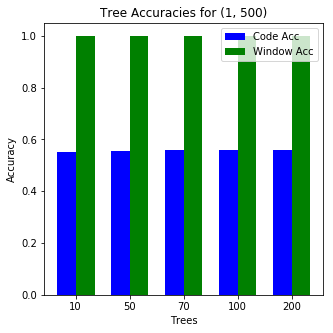

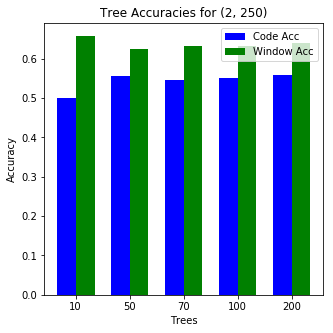

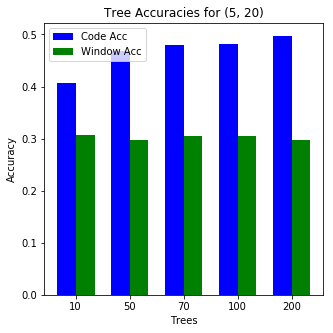

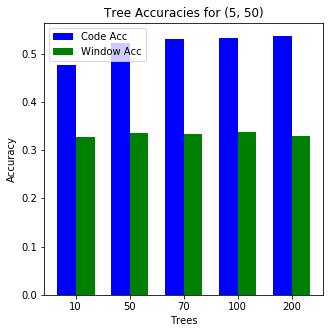

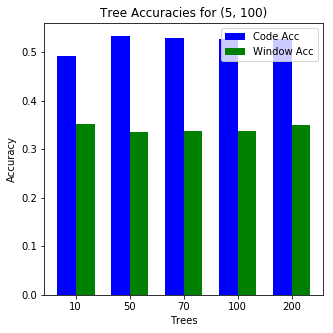

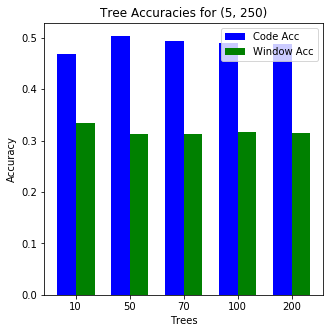

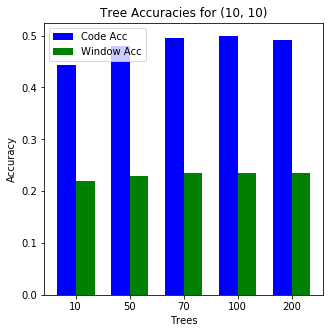

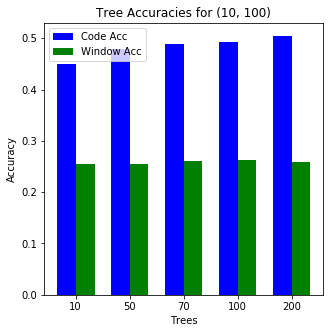

In [90]:
for tup in hyper_tuples:
    tup_key = tup
    tics = sorted(list(val_acc_all[tup].keys()))
    fig, ax = plt.subplots(figsize=(5,5))
    ind = np.arange(len(tics))
    width = 0.35
    code_acc = [val_acc_all[tup_key][key]['code'] for key in tics]
    window_acc = [np.mean(list(val_acc_all[tup_key][key]['window'].values())) for key in tics]
    rects1 = ax.bar(ind, code_acc, width, color='b')
    rects2 = ax.bar(ind + width, window_acc, width, color='g')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trees')
    ax.set_title('Tree Accuracies for {}'.format(tup_key))
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(tics)

    ax.legend((rects1[0], rects2[0]), ('Code Acc', 'Window Acc'))
    plt.show()

In [149]:
# setup with chosen parameters
num_trees = 200
num_windows, window_size = (2, 250)
train_combined, val_combined, test_combined = load_maps(num_windows, window_size)
X_train, X_train_map, y_train_code, _, y_train_window = get_code_window_batches(selected_codes, train_combined, num_windows, window_size)
X_test, X_test_map, y_test_code, y_test_code_map, y_test_window = get_code_window_batches(selected_codes, test_combined, num_windows, window_size)

# train
code_clf, window_clfs = create_two_stage_models(num_trees, num_trees, selected_codes)
code_clf.fit(X_train, y_train_code)
for code in selected_codes:
    window_clfs[code].fit(X_train_map[code], y_train_window[code])

In [148]:
for code in selected_codes:
    print(code, len(X_test_map[code]))

0 1000
45021 1000
44004 500
43004 0
45008 500
45002 500
45007 500


In [150]:
# test
code_scores = {}
window_scores = {}
for code in selected_codes:
    if len(X_test_map[code])>0:
        code_scores[code] = code_clf.score(X_test_map[code], y_test_code_map[code])
        window_scores[code] = window_clfs[code].score(X_test_map[code], y_test_window[code])
    
# features
print(code_clf.feature_importances_)

[  4.68043338e-04   9.22218927e-04   7.20912016e-03   1.39315677e-02
   7.14339888e-05   5.38632474e-02   1.27849396e-03   1.35202870e-03
   6.05820230e-04   1.77382249e-03   1.00518733e-04   1.37900914e-06
   1.23377997e-04   6.81208649e-04   1.49607647e-03   7.80485442e-02
   9.02132590e-05   1.38498104e-03   9.90168690e-04   6.08674782e-03
   1.85260837e-03   1.20632798e-03   5.36166797e-03   2.72644513e-03
   2.20397240e-03   2.05495221e-03   1.61588283e-03   1.46612211e-03
   1.91898960e-03   1.64089754e-03   1.01080545e-03   6.49189627e-04
   1.02186218e-03   1.48713581e-03   9.27229139e-02   1.08272544e-01
   9.13438121e-02   6.95615399e-02   7.32211780e-03   7.68663790e-03
   5.30370404e-03   3.66185493e-03   7.25264615e-04   1.57292344e-03
   1.70205395e-03   1.90335879e-03   1.30406430e-03   1.44762075e-03
   3.04349334e-03   4.49270376e-03   3.40901770e-03   2.77041948e-02
   1.01611441e-02   1.38869640e-02   5.06210998e-02   5.46437486e-02
   5.59368944e-02   5.71285281e-02

In [160]:
col_names = list(test_combined[519][44003][0][0])
[col_names[i] for i in np.argsort(code_clf.feature_importances_)[::-1]]

['Event - Amber Lamp Time Hr',
 'Event - All Lamps On Time Hr',
 'Event - Mil Lamp Time Hr',
 'Eng Avg Fuel Econ',
 'Event - Red Lamp Time Hr',
 'Lifetime Idle Fuel',
 'Lifetime Idle Hours',
 'Longitude',
 'Bus Utilization',
 'Latitude',
 'Lifetime Distance',
 'Lifetime Fuel',
 'Lifetime Engine Hours',
 'Altitude',
 'Barometric Press',
 'Engine Start Coolant',
 'Engine Start Ambient',
 'Exhaust Tank Temp',
 'Exhaust Tank Level',
 'Ambient Air Temp',
 'Eng DPF Intake Press',
 'Eng Fuel Del Press',
 'Fan Speed',
 'Trip Idle Time',
 'Keyswitch Bat Pot',
 'Trip Run Time',
 'Trip Distance',
 'EngFuelTemp1',
 'Engine Speed',
 'Eng Man Abs Pressure',
 'EngIntakeMan1Temp',
 'Scr Outlet Gas Temp',
 'Eng Egr Valve Pos',
 'Cmd Eng Fuel Press',
 'Scr Intake Gas Temp',
 'EngOilTemp1',
 'Eng Oil Pressure',
 'Part Trap Out Temp',
 'Eng Air Flow Rate',
 'EngTurbo1Speed',
 'EngInjRail1Press',
 'DTCID',
 'Eng Coolant Temp',
 'Cat Outlet Gas Temp',
 'Vehicle Speed',
 'Cat Intake Gas Temp',
 'Eng Exhaust 

In [62]:
len(train_combined[231][44003][0][0])

50

In [63]:
points = []
for i in range(5,-1,-1):
    points.extend(train_combined[231][44003][i][0]['EngInjRail1Press'])

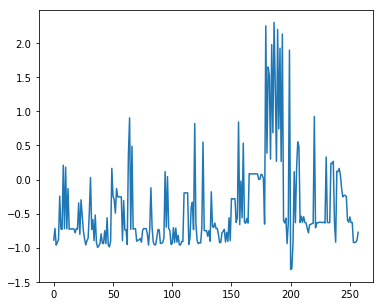

In [64]:
plt.figure()
plt.plot(range(len(points)), points)
plt.show()

In [65]:
len(train_combined[180][45002][0][0])

50

In [141]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [212]:
train_combined, val_combined, test_combined = load_maps(1, 500)

In [190]:
points = {}
#fields = ['Engine Start Coolant', 'Engine Start Ambient']#, 'EngTurbo1Speed']#, 'EngOilTemp1', 'Eng Oil Pressure', 'Eng Air Flow Rate', 'Eng Percent Torque']
fields = ['Event - Amber Lamp Time Hr',
 'Event - All Lamps On Time Hr',
 'Event - Mil Lamp Time Hr',
 'Eng Avg Fuel Econ',
 'Event - Red Lamp Time Hr',
 'Lifetime Idle Fuel',
 'Lifetime Idle Hours',
 'Longitude',
 'Bus Utilization']
for field in fields:
    points[field] = []
for i in range(len(train_combined[180][45002].keys())-1,-1,-1):
    for field in fields:
        points[field].extend(train_combined[180][45002][i][0][field])

In [196]:
fields_to_smooth = ['Acc Pedal Position',
 'Altitude',
 'Ambient Air Temp',
 'Barometric Press',
 'Bus Utilization',
 'Cat Intake Gas Temp',
 'Cat Outlet Gas Temp',
 'Cmd Eng Fuel Press',
 'Drvr Demand Torque',
 'Eng Air Flow Rate',
 'Eng Avg Fuel Econ',
 'Eng Coolant Temp',
 'Eng DPF Intake Press',
 'Eng Demand Torque',
 'Eng Egr Valve Pos',
 'Eng Exhaust Gas Temp',
 'Eng Fuel Del Press',
 'Eng Man Abs Pressure',
 'Eng Oil Pressure',
 'Eng Percent Torque',
 'EngFuelTemp1',
 'EngInjRail1Press',
 'EngIntakeMan1Temp',
 'EngOilTemp1',
 'EngTurbo1Boost',
 'EngTurbo1Pos',
 'EngTurbo1Speed',
 'Engine Speed',
 'Engine Start Ambient',
 'Engine Start Coolant',
 'Event - All Lamps On Time Hr',
 'Event - Amber Lamp Time Hr',
 'Event - Mil Lamp Time Hr',
 'Event - Red Lamp Time Hr',
 'Exhaust Tank Level',
 'Exhaust Tank Temp',
 'Fan Speed',
 'Keyswitch Bat Pot',
 'Latitude',
 'Lifetime Distance',
 'Lifetime Engine Hours',
 'Lifetime Fuel',
 'Lifetime Idle Fuel',
 'Lifetime Idle Hours',
 'Longitude',
 'Part Trap Diff Press',
 'Part Trap Out Temp',
 'Scr Intake Gas Temp',
 'Scr Outlet Gas Temp',
 'Trip Distance',
 'Trip Idle Time',
 'Trip Run Time',
 'Vehicle Speed']

In [207]:
smooth_data(train_combined[180][45002][0][0], fields_to_smooth)

,Event Type Description,Acc Pedal Position,Ambient Air Temp,Barometric Press,Brake Switch,Bus Utilization,Cat Intake Gas Temp,Cat Outlet Gas Temp,Clutch Switch,Cmd Eng Fuel Press,...,Altitude,Engine Start Ambient,Engine Start Coolant,Latitude,Longitude,Lifetime Idle Hours,Lifetime Idle Fuel,Lifetime Fuel,Lifetime Distance,Lifetime Engine Hours
128734,0,54.514155,-0.755176,0.530374,0,1.147875,1.030127,0.951665,0,0.779603,...,0.102349,-0.011107,-0.001531,-0.970770,0.093514,-0.662041,-0.659359,-0.898871,-0.915511,60.090599
128732,0,54.705506,-0.749458,0.518764,0,1.152181,1.028321,0.950056,0,0.782288,...,0.102349,-0.011107,-0.001531,-0.970333,0.093746,-0.660856,-0.658239,-0.896094,-0.912251,61.250983
128735,0,54.910017,-0.743996,0.505805,0,1.156312,1.026854,0.948781,0,0.785133,...,0.102349,-0.011107,-0.001531,-0.969468,0.093062,-0.659680,-0.657131,-0.893331,-0.908990,62.407664
128733,0,55.129638,-0.738773,0.491542,0,1.160284,1.025843,0.947950,0,0.788219,...,0.102349,-0.011107,-0.001531,-0.968216,0.091389,-0.658515,-0.656036,-0.890581,-0.905728,63.560783
128726,1,55.364266,-0.733779,0.476032,0,1.164105,1.025415,0.947681,0,0.791631,...,0.102349,-0.011107,-0.001531,-0.966622,0.088652,-0.657359,-0.654954,-0.887842,-0.902463,64.710535
128641,1,55.612957,-0.729010,0.459341,0,1.167788,1.025659,0.948066,0,0.795410,...,0.102349,-0.011107,-0.001531,-0.964728,0.084781,-0.656215,-0.653885,-0.885113,-0.899194,65.857168
128645,1,55.874708,-0.724420,0.441516,0,1.171329,1.026617,0.949154,0,0.799562,...,0.102349,-0.011107,-0.001531,-0.962581,0.079709,-0.655081,-0.652828,-0.882391,-0.895921,67.000930
128638,1,56.146774,-0.719965,0.422608,0,1.174711,1.028260,0.950928,0,0.804049,...,0.102349,-0.011107,-0.001531,-0.960224,0.073371,-0.653959,-0.651785,-0.879675,-0.892641,68.141996
128637,1,56.426279,-0.715653,0.402678,0,1.177921,1.030543,0.953337,0,0.808818,...,0.102350,-0.011107,-0.001531,-0.957696,0.065711,-0.652850,-0.650756,-0.876963,-0.889354,69.280488
128631,1,56.710110,-0.711473,0.381765,0,1.180945,1.033422,0.956337,0,0.813833,...,0.102350,-0.011107,-0.001531,-0.955029,0.056684,-0.651754,-0.649742,-0.874253,-0.886059,70.416516


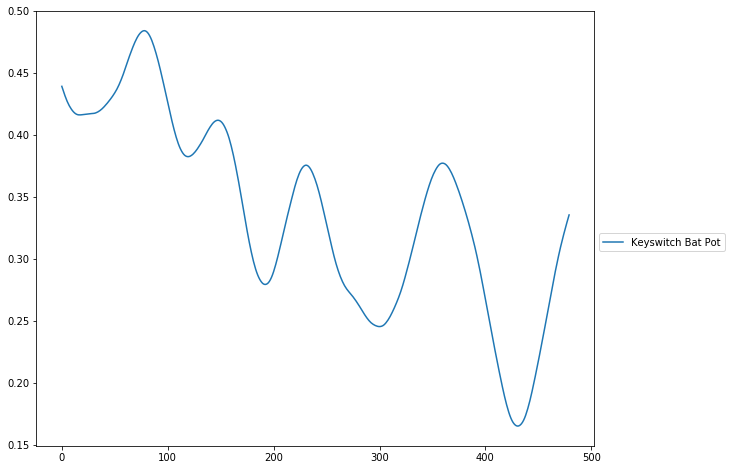

In [213]:
plt.figure()
# for field in fields:
#     x = points[field]
#     window_len = 100
#     s=np.r_[x[window_len:0:-1],x,x[-2:-window_len:-1]]
#     w = np.hanning(window_len)
#     y = np.convolve(w/w.sum(),s,mode='valid')
#     #y=points[field]
#     plt.plot(range(len(points[field])+window_len-1), y, label=field)
#     #plt.plot(range(len(points[field])), y, label=field)
plt.plot(range(len(train_combined[180][45002][0][0])), train_combined[180][45002][0][0]['Keyswitch Bat Pot'])
plt.legend(loc="best", bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
plt.figure()
for field in fields:
    x = range(len(points[field]))
    f = interp1d(x, points[field])
    plt.plot(x, f(points[field]), label=field)
plt.legend(loc="best", bbox_to_anchor=(1, 0.5))
plt.show()

In [161]:
col_names[np.argmax(code_clf.feature_importances_)]

'Event - Amber Lamp Time Hr'

In [ ]:
## two-stage with mean and standard deviation rating